<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-06-03 08:14:09--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-06-03 08:14:09 (229 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



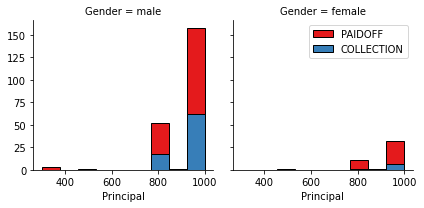

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

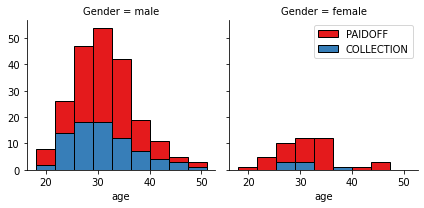

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


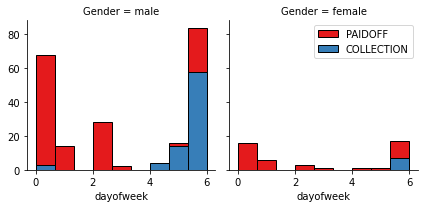

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#Performing a train/test split on dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [21]:
#Importing the Knearest neighbors classifier and metrics for the algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k = 10

mean_accuracy = np.zeros((k-1))
std_accuracy = np.zeros((k-1))

confusion_matrix = []

for i in range(1, k):
    model_neigh = KNeighborsClassifier(n_neighbors = i)
    model_neigh.fit(X_train, y_train)
    Yhat = model_neigh.predict(X_test)
    
    mean_accuracy[i-1] = metrics.accuracy_score(y_test, Yhat)
    std_accuracy[i-1] = np.std(Yhat == y_test)/np.sqrt(Yhat.shape[0])
    
print(mean_accuracy)

[0.65384615 0.64423077 0.78846154 0.74038462 0.77884615 0.81730769
 0.78846154 0.76923077 0.78846154]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Legend does not support 'u' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Legend d

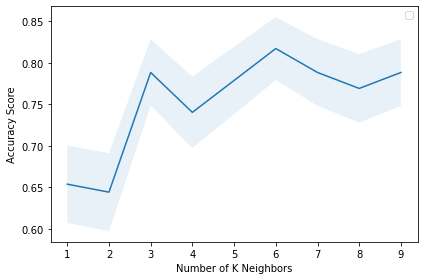

The best accuracy score is 0.8173076923076923 with k neighbors = 6


KNeighborsClassifier(n_neighbors=6)

In [22]:
# Visualize model
plt.plot(range(1, k), mean_accuracy)
plt.fill_between(range(1, k), mean_accuracy - 1 * std_accuracy, mean_accuracy + 1 * std_accuracy, alpha = 0.10)

plt.xlabel('Number of K Neighbors')
plt.ylabel('Accuracy Score')
plt.legend('Accuracy', '+/- 3xstd')
plt.tight_layout()
plt.show()

print('The best accuracy score is', mean_accuracy.max(), 'with k neighbors =', mean_accuracy.argmax() + 1)

model_neigh = KNeighborsClassifier(n_neighbors = mean_accuracy.argmax() + 1)
model_neigh.fit(X_train, y_train)

# Decision Tree


In [23]:
#Importing a few libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.image as mpimg
from sklearn import tree
from io import StringIO

%matplotlib inline 
## Creating the tree model
model_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)
model_tree.fit(X_train, y_train)

# Model Prediction
pred = model_tree.predict(X_test)
print(pred[0:5])
print(y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']


In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, pred))

Decision Trees's Accuracy:  0.7019230769230769


In [25]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

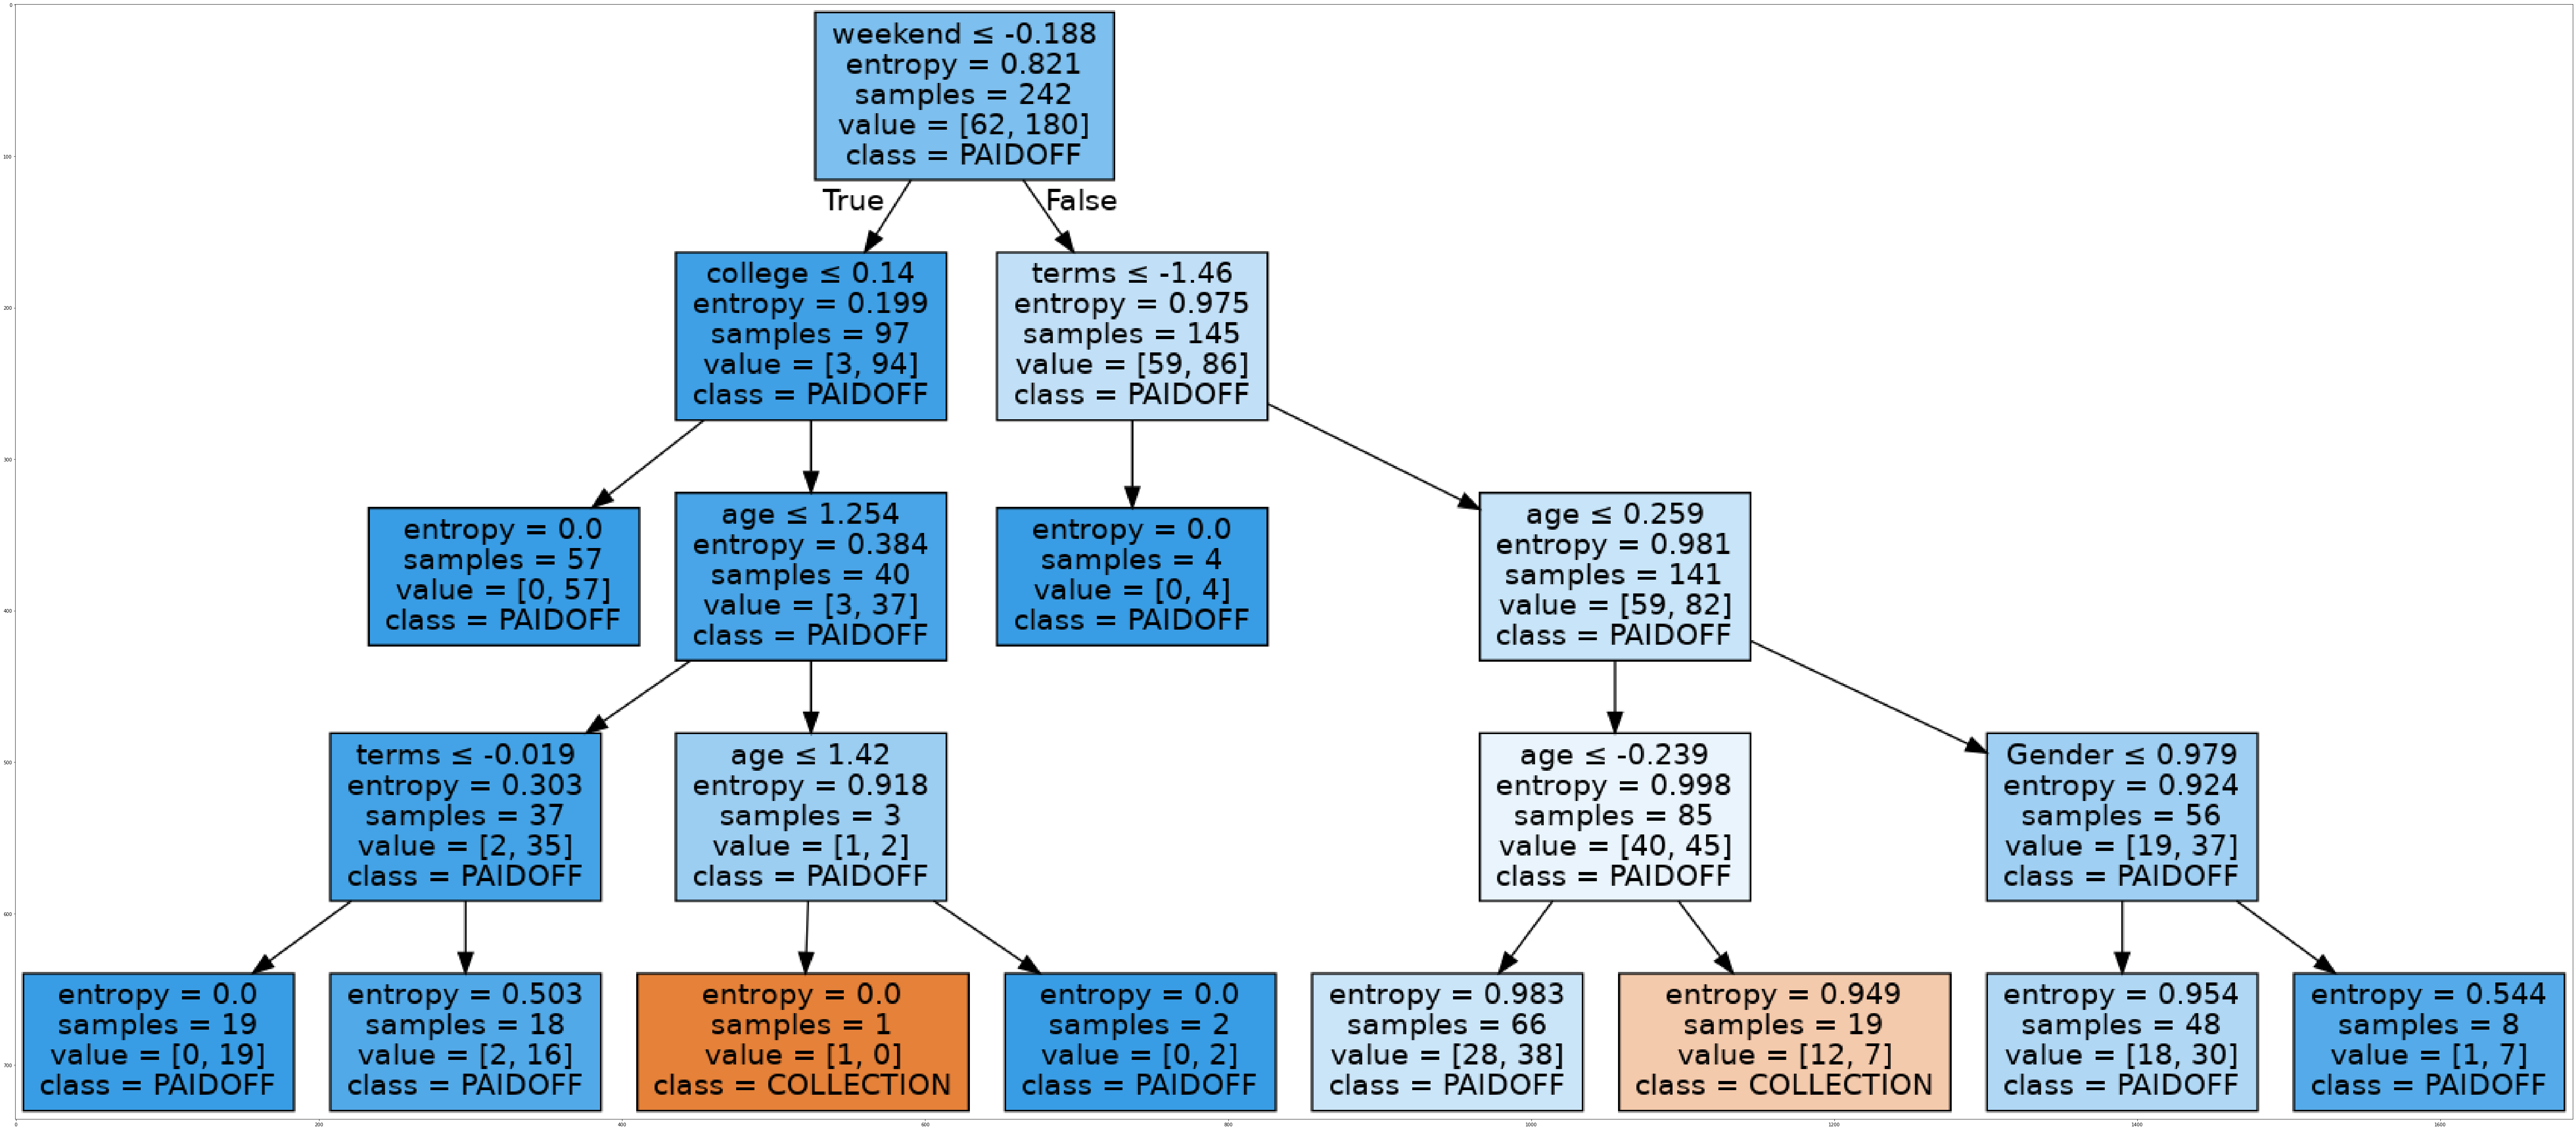

In [27]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = Feature.columns
out=tree.export_graphviz(model_tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [28]:
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn import svm

In [29]:
# SVM modelling
svm_model = svm.SVC(kernel = 'sigmoid', gamma = 'auto')
svm_model.fit(X_train, y_train)

#Prediction on test data
pred_svm = svm_model.predict(X_test)

In [30]:
# Metrics Evaluation
from sklearn.metrics import f1_score

f1_score(y_test, pred_svm, average = 'weighted')

0.6525349650349651

# Logistic Regression


In [31]:
# Modelling the logistic regression
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C = 0.01, solver = 'liblinear')
logit.fit(X_train, y_train)

# Prediction
pred_logit = logit.predict(X_test)
pred_logit_m = logit.predict_proba(X_test)

In [32]:
# Evaluation Metrics
from sklearn.metrics import jaccard_score
jaccard_score(y_test, pred_logit, average = None)[1]

0.7692307692307693

# Model Evaluation using Test set


In [82]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [83]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-06-03 08:59:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-06-03 08:59:27 (106 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [84]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [94]:
# Preprocess all the fields:
test_features = pd.DataFrame()
test_labels = pd.DataFrame()

# Convert dates to day of week
test_features['origination_day_of_week'] = pd.to_datetime(test_df['effective_date']).dt.dayofweek
test_features['due_day_of_week'] = pd.to_datetime(test_df['due_date']).dt.dayofweek

# Convert education and gender to numerical values (I don't see a need for one-hot encoding here)
test_features['gender'] = test_df['Gender'].replace(to_replace=['male','female'], value=[0,1])
test_features['education'] = test_df['education'].replace(to_replace=['Bechalor','High School or Below', 'Master or Above', 'college'], value=[0.0, 0.33, 0.67, 1.0])

# Normalize Principal, terms and age using z-score normalization
test_features['principal'] = (test_df['Principal'] - np.mean(test_df['Principal'])) / np.std(test_df['Principal'])
test_features['terms'] = (test_df['terms'] - np.mean(test_df['terms'])) / np.std(test_df['terms'])
test_features['age'] = (test_df['age'] - np.mean(test_df['age'])) / np.std(test_df['age'])

# Convert loan status to numerical values
test_labels['status'] = test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1])

In [96]:
"""
knn_pred=neigh.predict(TestX)
jc1=jaccard_similarity_score(TestY, knn_pred)
fs1=f1_score(TestY, knn_pred, average='weighted')

tree_pred=modeltree.predict(TestX)
jc2=jaccard_similarity_score(TestY, tree_pred)
fs2=f1_score(TestY, tree_pred, average='weighted')

svm_pred=clf.predict(TestX)
jc3=jaccard_similarity_score(TestY, svm_pred)
fs3=f1_score(TestY, svm_pred, average='weighted')

log_pred=LR.predict(TestX)
proba=LR.predict_proba(TestX)
jc4=jaccard_similarity_score(TestY, log_pred)
fs4=f1_score(TestY, log_pred, average='weighted')  
ll4=log_loss(TestY, proba)
"""

list_jc = [0.7, 0.72, 0.740741, 0.754717]
list_fs = [0.823529, 0.837209, 0.851064, 0.860215]
list_ll = ['NA', 'NA', 'NA', 8.31508]


import pandas as pd

# fomulate the report format
list_scores = {'Jaccard': list_jc, 'F1-score': list_fs, 'LogLoss': list_ll}
df = pd.DataFrame(list_scores, index = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'])
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.700000,0.823529,NA
Decision Tree,0.720000,0.837209,NA
SVM,0.740741,0.851064,NA
Logistic Regression,0.754717,0.860215,8.31508


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>About the Author:</h2> 

<a href="https://www.linkedin.cn/in/appiah-elijah-383231123/"><strong>Elijah Appiah</strong></a> holds a Bachelor of Arts (Honors) degree in Economics from the University of Education, Winneba in Ghana; and holds keen interest in Data Science and Artificial Intelligence. He is currently pursuing a Master of Philosophy degree in Economics at the same university and is a **Graduate Teaching Assistant**, assisting in teaching the course "Mathematics for Economists" at the undergraduate level. **Elijah has published two books entitled: "Data Analysis with R Programming" and "Simplified Mathematical Economics".**

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
